In [1]:
import os
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine, text

# Wenn dein Notebook in notebooks/ liegt und .env im Projekt-Root:
load_dotenv(Path("..") / ".env")

DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")          # <- dein Key
DB_PASS = os.getenv("DB_PASSWORD")

assert DB_HOST and DB_NAME and DB_USER, "Fehlende DB-Variablen (DB_HOST/DB_NAME/DB_USER)"

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# Test
with engine.connect() as conn:
    print(conn.execute(text("SELECT current_user, current_database()")).fetchone())


('postgres', 'mimic')


In [2]:
import pandas as pd
from sqlalchemy import text

AKI_ONLY = True  # False = alle Patienten/Aufenthalte

def q(sql: str) -> pd.DataFrame:
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)


In [3]:
# AKI-Kohorte (MIMIC-III) über ICD-9: 584%
sql_aki = """
WITH aki_hadm AS (
  SELECT DISTINCT subject_id, hadm_id
  FROM diagnoses_icd
  WHERE icd9_code LIKE '584%'
)
SELECT i.subject_id, i.hadm_id, i.icustay_id, i.intime, i.outtime
FROM icustays i
JOIN aki_hadm a
  ON a.subject_id = i.subject_id AND a.hadm_id = i.hadm_id
ORDER BY i.subject_id, i.hadm_id, i.icustay_id;
"""

aki_cohort = q(sql_aki)
aki_cohort.head()


,subject_id,hadm_id,icustay_id,intime,outtime
0,3,145834,211552,2101-10-20 19:10:11,2101-10-26 20:43:09
1,9,150750,220597,2149-11-09 13:07:02,2149-11-14 20:52:14
2,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32
3,38,185910,248910,2166-08-10 00:29:36,2166-09-04 13:39:23
4,52,190797,261857,2191-01-10 02:12:55,2191-01-11 22:37:31


In [4]:
sql_aki_demo = """
WITH aki_hadm AS (
  SELECT DISTINCT subject_id, hadm_id
  FROM diagnoses_icd
  WHERE icd9_code LIKE '584%'
)
SELECT
  i.subject_id,
  i.hadm_id,
  i.icustay_id,
  p.gender,
  p.dob,
  adm.admittime,
  adm.dischtime,
  adm.deathtime,
  adm.ethnicity,
  EXTRACT(YEAR FROM age(adm.admittime, p.dob)) AS age,
  CASE
    WHEN adm.deathtime IS NOT NULL THEN 1
    ELSE 0
  END AS hospital_mortality
FROM icustays i
JOIN aki_hadm a
  ON a.subject_id = i.subject_id AND a.hadm_id = i.hadm_id
JOIN patients p
  ON p.subject_id = i.subject_id
JOIN admissions adm
  ON adm.subject_id = i.subject_id AND adm.hadm_id = i.hadm_id
ORDER BY i.subject_id, i.hadm_id, i.icustay_id;
"""

aki_demo = q(sql_aki_demo)
aki_demo.head()


,subject_id,hadm_id,icustay_id,gender,dob,admittime,dischtime,deathtime,ethnicity,age,hospital_mortality
0,3,145834,211552,M,2025-04-11,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,WHITE,76.0,0
1,9,150750,220597,M,2108-01-26,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,UNKNOWN/NOT SPECIFIED,41.0,1
2,21,109451,217847,M,2047-04-04,2134-09-11 12:17:00,2134-09-24 16:15:00,NaT,WHITE,87.0,0
3,38,185910,248910,M,2090-08-31,2166-08-10 00:28:00,2166-09-04 11:30:00,NaT,WHITE,75.0,0
4,52,190797,261857,M,2152-11-26,2191-01-10 02:12:00,2191-01-19 16:10:00,NaT,WHITE,38.0,0


In [5]:
aki_demo["hospital_mortality"].mean()




np.float64(0.2343349638947123)

In [6]:
# Filtere: nur Alter zwischen 18 und 90 (einschließlich)
aki_demo = aki_demo[aki_demo["age"].between(18, 90)]


In [7]:
aki_demo["age"].describe()


count    11926.000000
mean        65.624602
std         14.998701
min         18.000000
25%         55.000000
50%         68.000000
75%         78.000000
max         89.000000
Name: age, dtype: float64

<Axes: ylabel='Frequency'>

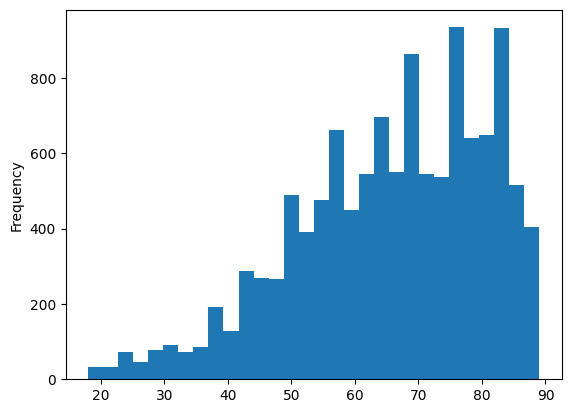

In [8]:
aki_demo["age"].plot.hist(bins=30)


In [9]:
aki_demo["gender"].value_counts(normalize=True)


gender
M    0.588546
F    0.411454
Name: proportion, dtype: float64

In [10]:
aki_demo["ethnicity"].value_counts(normalize=True).head(10)


ethnicity
WHITE                             0.699229
BLACK/AFRICAN AMERICAN            0.120241
UNKNOWN/NOT SPECIFIED             0.060624
HISPANIC OR LATINO                0.023897
OTHER                             0.019118
UNABLE TO OBTAIN                  0.017692
ASIAN                             0.014506
PATIENT DECLINED TO ANSWER        0.007211
HISPANIC/LATINO - PUERTO RICAN    0.005283
WHITE - RUSSIAN                   0.004696
Name: proportion, dtype: float64

In [11]:
aki_demo.groupby("gender")["hospital_mortality"].mean()


gender
F    0.225596
M    0.234934
Name: hospital_mortality, dtype: float64

In [13]:
aki_demo.groupby("ethnicity")["hospital_mortality"].mean()


ethnicity
AMERICAN INDIAN/ALASKA NATIVE                               0.142857
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE    0.500000
ASIAN                                                       0.260116
ASIAN - ASIAN INDIAN                                        0.052632
ASIAN - CAMBODIAN                                           0.083333
ASIAN - CHINESE                                             0.277778
ASIAN - FILIPINO                                            0.083333
ASIAN - JAPANESE                                            1.000000
ASIAN - KOREAN                                              0.333333
ASIAN - OTHER                                               0.000000
ASIAN - VIETNAMESE                                          0.416667
BLACK/AFRICAN                                               0.083333
BLACK/AFRICAN AMERICAN                                      0.154114
BLACK/CAPE VERDEAN                                          0.108108
BLACK/HAITIAN           

In [15]:
# Ethnien auf große Hauptgruppen reduzieren
def map_ethnicity(e):
    if pd.isna(e):
        return "OTHER"
    e = e.upper()
    if "WHITE" in e:
        return "WHITE"
    if "BLACK" in e or "AFRICAN" in e:
        return "BLACK"
    if "HISPANIC" in e or "LATINO" in e:
        return "HISPANIC"
    if "ASIAN" in e:
        return "ASIAN"
    return "OTHER"

aki_demo["ethnicity_group"] = aki_demo["ethnicity"].apply(map_ethnicity)

# Verteilung der großen Ethnie-Gruppen
print(aki_demo["ethnicity_group"].value_counts(normalize=True))

# Mortalität nach großen Ethnie-Gruppen
aki_demo.groupby("ethnicity_group")["hospital_mortality"].mean().sort_values(ascending=False)


ethnicity_group
WHITE       0.707614
BLACK       0.126614
OTHER       0.109509
HISPANIC    0.032031
ASIAN       0.024233
Name: proportion, dtype: float64


ethnicity_group
OTHER       0.353752
ASIAN       0.242215
WHITE       0.227989
HISPANIC    0.183246
BLACK       0.152318
Name: hospital_mortality, dtype: float64